In [1]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import json

from keras.preprocessing.text import tokenizer_from_json
from keras import models
from keras.preprocessing import sequence

from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:


model = models.load_model('../archives/model_textcnn_imbd.h5')

maxlen = 2439

with open('../archives/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

C:\Users\jcmor\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [4]:
def model_apply(lst_reviews):
    tokenize_reviews = tokenizer.texts_to_sequences(lst_reviews)
    sequence_reviews = sequence.pad_sequences(tokenize_reviews, padding = 'post', 
                                         truncating = 'post', maxlen=maxlen)
    predict_reviews = model.predict(sequence_reviews)
    positive_reviews = 0
    negative_reviews = 0
    for predict_review in predict_reviews:
        if predict_review[0] > 0.5:
            positive_reviews += 1
        else:
            negative_reviews += 1
    print(color.BOLD + f"It has {positive_reviews} positive reviews and {negative_reviews} negative reviews" + color.END)

In [5]:
def examine_reviews(result):
    lst_reviews = []
    movie_id = result['id'][7:-1]
    
    
    
    url = "https://imdb8.p.rapidapi.com/title/get-user-reviews"

    querystring = {"tconst":f"{movie_id}"}

    headers = {
    'x-rapidapi-host': "imdb8.p.rapidapi.com",
    'x-rapidapi-key': "c22c9a41ccmsha1cb34689d4a655p1c81c6jsnc8f288db2c6b"
    }

    response_reviews = requests.request("GET", url, headers=headers, params=querystring)
    
    json_reviews = response_reviews.json()
    
    
    total_results = json_reviews['totalReviews']
    key = json_reviews['paginationKey']
    if total_results == 0:
        print(color.BOLD + 'There are not reviews' + color.END)
    else:
        print(color.BOLD + f'It has {total_results} reviews' + color.END)
        num_reviews = int(input(color.BOLD + 'How many reviews do you want check: '+ color.END))
        num_reviews = min(num_reviews, total_results)
        print(color.BOLD + f"Let's check {num_reviews} reviews" + color.END)
        cont =0
        while num_reviews > 0:
            lst_reviews.append(json_reviews['reviews'][cont]['reviewText'])
            cont += 1
            num_reviews -= 1
            if cont == 25:
                cont = 0
                url = "https://imdb8.p.rapidapi.com/title/get-user-reviews"

                querystring = {"paginationKey":f"{key}","tconst": f"{movie_id}"}

                headers = {'x-rapidapi-host': "imdb8.p.rapidapi.com",
                            'x-rapidapi-key': "c22c9a41ccmsha1cb34689d4a655p1c81c6jsnc8f288db2c6b"
                            }

                response_reviews = requests.request("GET", url, headers=headers, params=querystring)
                json_reviews = response_reviews.json()
                key = json_reviews['paginationKey']
        model_apply(lst_reviews)

In [6]:
def main():
    correct = True
    num_search = 0
    cont = 0
       
    url = "https://imdb8.p.rapidapi.com/title/find"

    movie = input(color.BOLD + 'Enter the name of a movie or a TV show: '+ color.END)

    querystring = {"q":movie}

    headers = {
    'x-rapidapi-host': "imdb8.p.rapidapi.com",
    'x-rapidapi-key': "c22c9a41ccmsha1cb34689d4a655p1c81c6jsnc8f288db2c6b"
    }
    
    response = requests.request("GET", url, headers=headers, params=querystring)
    
    json = response.json()
    num_search = len(json['results'])
    
    if num_search == 0:
        print(color.BOLD + "I can't find it, try it again" + color.END)

    while correct and num_search > 0:
        result = json['results'][cont]
        response_image = requests.get(result['image']['url'])
        img = Image.open(BytesIO(response_image.content))
        plt.figure(figsize=(20,10))
        plt.axis('off')
        imgplot = plt.imshow(img)
        plt.show()
        answer = input(color.BOLD + "Is it correct? Type yes/no\n" + color.END) 
        if answer == 'yes':
            examine_reviews(result)
            break
        elif answer == 'no':
            cont += 1
            num_search -= 1
            clear_output(wait=True)
            continue
        else:
            print(color.BOLD + 'An error occurred' + color.END)
            break

        if num_search == 0:
            print(color.BOLD + "I can't find the movie, try again" + color.END)
            break

Enter the name of a movie or a TV show: joker


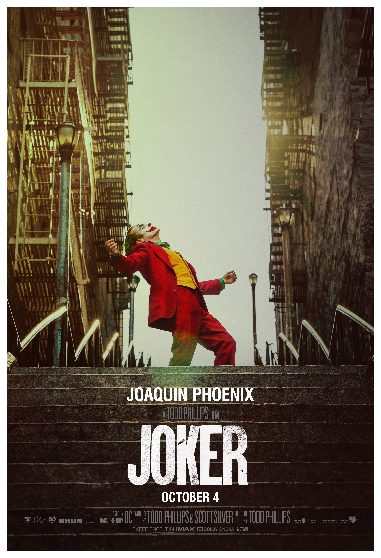

Is it correct? Type yes/no
yes
It has 10132 reviews
How many reviews do you want check: 20
Let's check 20 reviews
It has 18 positive reviews and 2 negative reviews


In [7]:
main()